In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kitti-dataset/kitti.yaml
/kaggle/input/kitti-dataset/labels/val/005063.txt
/kaggle/input/kitti-dataset/labels/val/006003.txt
/kaggle/input/kitti-dataset/labels/val/003708.txt
/kaggle/input/kitti-dataset/labels/val/002801.txt
/kaggle/input/kitti-dataset/labels/val/006771.txt
/kaggle/input/kitti-dataset/labels/val/005908.txt
/kaggle/input/kitti-dataset/labels/val/005241.txt
/kaggle/input/kitti-dataset/labels/val/004824.txt
/kaggle/input/kitti-dataset/labels/val/001662.txt
/kaggle/input/kitti-dataset/labels/val/000169.txt
/kaggle/input/kitti-dataset/labels/val/006612.txt
/kaggle/input/kitti-dataset/labels/val/005727.txt
/kaggle/input/kitti-dataset/labels/val/006310.txt
/kaggle/input/kitti-dataset/labels/val/001768.txt
/kaggle/input/kitti-dataset/labels/val/000392.txt
/kaggle/input/kitti-dataset/labels/val/004427.txt
/kaggle/input/kitti-dataset/labels/val/003519.txt
/kaggle/input/kitti-dataset/labels/val/006113.txt
/kaggle/input/kitti-dataset/labels/val/000730.txt
/kaggle/inp

# Real-Time Object Detection for Autonomous Vehicles  
## Milestone 1: Data Collection, Exploration & Preprocessing

**Dataset:** KITTI (YOLO formatted)  

This notebook documents each step (tasks that are not needed are explicitly marked).


### Environment setup & copy dataset

In [3]:
# Cell: Setup - adjust dataset_dir to your Kaggle dataset name (visible in the right Data pane)
import os
import shutil
from pathlib import Path

KAGGLE_INPUT_DIR = "/kaggle/input" 

DATASET_NAME = "kitti-dataset"  

input_dataset_path = os.path.join(KAGGLE_INPUT_DIR, DATASET_NAME)
working_root = "/kaggle/working/kitti"

print("Input dataset path:", input_dataset_path)
print("Working copy path:", working_root)

# Copy to working directory (faster read/write)
if os.path.exists(working_root):
    print("Working folder already exists — skipping copy.")
else:
    print("Copying dataset to working directory (this may take a while)...")
    shutil.copytree(input_dataset_path, working_root)
    print("Copy complete.")
    
# list top-level files
print("Top-level files in working dir:")
print(os.listdir(working_root))


Input dataset path: /kaggle/input/kitti-dataset
Working copy path: /kaggle/working/kitti
Copying dataset to working directory (this may take a while)...
Copy complete.
Top-level files in working dir:
['kitti.yaml', 'labels', 'images']


### Data Collection 

#### Confirm dataset structure & counts

In [4]:
from glob import glob
from pprint import pprint

root = Path(working_root)
images_train = sorted((root/"images/train").glob("*.*"))
images_val = sorted((root/"images/val").glob("*.*"))
labels_train = sorted((root/"labels/train").glob("*.txt"))
labels_val = sorted((root/"labels/val").glob("*.txt"))
yaml_file = root/"kitti.yaml"

print("Found yaml:", yaml_file.exists(), yaml_file)
print("Train images:", len(images_train))
print("Val images:", len(images_val))
print("Train labels:", len(labels_train))
print("Val labels:", len(labels_val))

# show sample paths
pprint({
    "images_train_sample": [str(p.name) for p in images_train[:5]],
    "labels_train_sample": [str(p.name) for p in labels_train[:5]],
})


Found yaml: True /kaggle/working/kitti/kitti.yaml
Train images: 5985
Val images: 1496
Train labels: 5985
Val labels: 1496
{'images_train_sample': ['000002.png',
                         '000003.png',
                         '000004.png',
                         '000005.png',
                         '000006.png'],
 'labels_train_sample': ['000002.txt',
                         '000003.txt',
                         '000004.txt',
                         '000005.txt',
                         '000006.txt']}


### Data Exploration

#### Analyzing distribution of object classes

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

def count_classes(label_files):
    """Count how many times each class appears in label files"""
    class_counter = Counter()
    
    for label_file in label_files:
        try:
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:  # Valid YOLO line: class x y w h
                        class_id = int(parts[0])
                        class_counter[class_id] += 1
        except:
            continue
    
    return class_counter

# Count classes in training and validation sets
train_class_counts = count_classes(labels_train)
val_class_counts = count_classes(labels_val)

print("TRAINING SET:")
print(f"Total images: {len(images_train)}")
print(f"Classes found: {dict(train_class_counts)}")
print(f"Total objects: {sum(train_class_counts.values())}")

print("\nVALIDATION SET:")
print(f"Total images: {len(images_val)}")
print(f"Classes found: {dict(val_class_counts)}")
print(f"Total objects: {sum(val_class_counts.values())}")

TRAINING SET:
Total images: 5985
Classes found: {7: 765, 0: 23026, 3: 3566, 5: 1275, 2: 871, 6: 394, 1: 2359, 4: 186}
Total objects: 32442

VALIDATION SET:
Total images: 1496
Classes found: {3: 921, 2: 223, 0: 5716, 5: 352, 1: 555, 6: 117, 7: 208, 4: 36}
Total objects: 8128


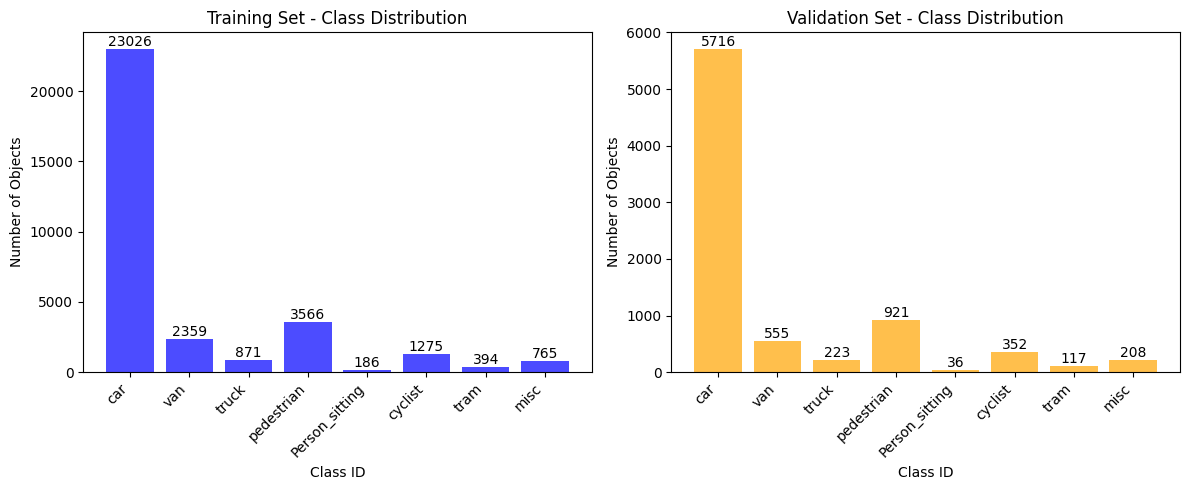

In [6]:
# Plot class distributions
plt.figure(figsize=(12, 5))
classes_list=['car','van','truck','pedestrian','Person_sitting','cyclist','tram','misc']
# Training set plot
plt.subplot(1, 2, 1)
classes = sorted(train_class_counts.keys())
counts = [train_class_counts[cls] for cls in classes]
plt.bar(classes_list, counts, color='blue', alpha=0.7)
plt.title('Training Set - Class Distribution')
plt.xlabel('Class ID')
plt.ylabel('Number of Objects')
for i, count in enumerate(counts):
    plt.text(classes[i], count, str(count), ha='center', va='bottom')
plt.xticks(rotation=45, ha='right') # Rotate the x-labels by 45 degrees

# Validation set plot
plt.subplot(1, 2, 2)
classes = sorted(val_class_counts.keys())
counts = [val_class_counts[cls] for cls in classes]
plt.bar(classes_list, counts, color='orange', alpha=0.7)
plt.title('Validation Set - Class Distribution')
plt.xlabel('Class ID')
plt.ylabel('Number of Objects')
for i, count in enumerate(counts):
    plt.text(classes[i], count, str(count), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right') # Rotate the x-labels by 45 degrees

plt.tight_layout()
plt.show()

#### Display random example images with boxes

In [7]:
def read_yolo_label(txt_path):
    # returns list of dicts: {'class': int, 'x':, 'y':, 'w':, 'h':} (normalized)
    objs = []
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5: 
                continue
            cls = int(parts[0])
            x, y, w, h = map(float, parts[1:])
            objs.append({'class': cls, 'x': x, 'y': y, 'w': w, 'h': h})
    return objs

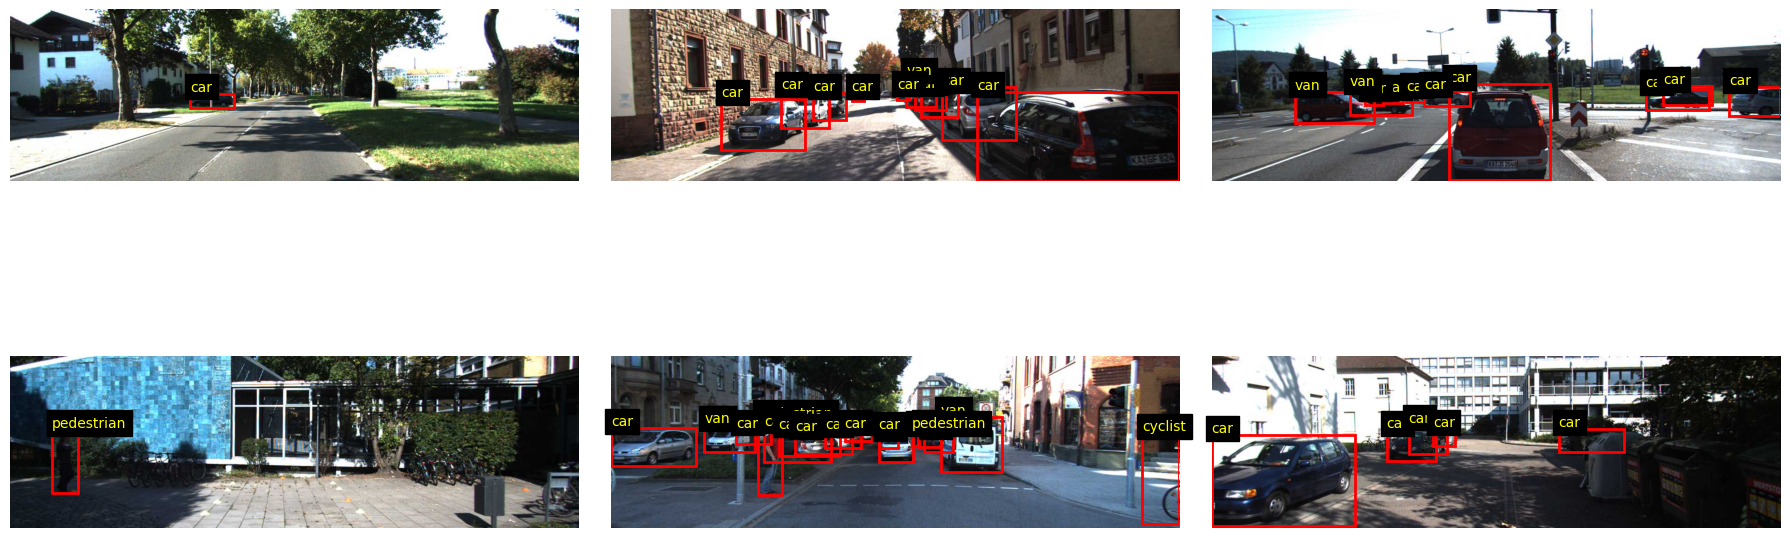

In [9]:
import random, cv2
from IPython.display import display, Image as IPImage
from matplotlib.patches import Rectangle

def show_image_with_boxes(img_path, lbl_path, ax=None):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    h,w,_ = img.shape
    objs = read_yolo_label(lbl_path)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10,6))
    ax.imshow(img)
    for o in objs:
        xc = o['x']*w; yc = o['y']*h; bw=o['w']*w; bh=o['h']*h
        xmin = xc-bw/2; ymin = yc-bh/2
        rect = Rectangle((xmin,ymin), bw, bh, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        cls_name = classes_list[o['class']]
        ax.text(xmin, ymin-6, cls_name, color='yellow', fontsize=10, backgroundcolor='black')
    ax.axis('off')
    return ax

# show 6 random train images
sample = random.sample(images_train, min(6, len(images_train)))
fig, axes = plt.subplots(2,3, figsize=(18,9))
axes = axes.flatten()
for i, p in enumerate(sample):
    lbl = root/"labels"/"train"/(p.stem + ".txt")
    show_image_with_boxes(p, lbl, axes[i])
plt.tight_layout()
plt.show()

### Data Preprocessing

for this part Yolo 11 already handles all the preprocessing part as it does the following: # During training, YOLO 11 automatically:
- 1. Loads images (any size)
- 2. Resizes to your specified imgsz (e.g., 640)
- 3. Normalizes pixels: 0-255 → 0.0-1.0
- 4. Applies data augmentation
- 5. Converts to proper tensor format

## Milestone 2: Object Detection Model Development 

### Quick Model screening 
trying each yolo model for 2,3 epochs 

In [10]:
!uv pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.229 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6565.7/8062.4 GB disk)


In [11]:
from ultralytics import YOLO
import time
import pandas as pd
import matplotlib.pyplot as plt

def quick_model_screening():
    """Test multiple models with few epochs to find the best one out of them"""
    
    models_to_test = [
        {"name": "YOLO11n", "path": "yolo11n.pt", "params": "2.5M"},
        {"name": "YOLO11s", "path": "yolo11s.pt", "params": "6.0M"}, 
        {"name": "YOLO11m", "path": "yolo11m.pt", "params": "18.0M"},
    ]
    
    screening_results = {}
    
    for model_config in models_to_test:
        print(f"\n🔍 SCREENING: {model_config['name']} ({model_config['params']})")
        
        try:
            # Load model
            model = YOLO(model_config["path"])
            
            # Quick training (2-3 epochs only for screening)
            results = model.train(
                data="kitti.yaml",
                epochs=3,  # SMALL epochs for quick screening
                imgsz=640,
                batch=16,
                patience=2,  # Early stopping
                verbose=False,  # Cleaner output
                save=False,     # Don't save screening models
            )
            
            # Quick validation
            metrics = model.val()
            
            # Measure FPS
            fps = measure_inference_speed(model)
            
            # Store results
            screening_results[model_config["name"]] = {
                "mAP50": metrics.box.map50,
                "mAP50_95": metrics.box.map,
                "precision": metrics.box.p,
                "recall": metrics.box.r,
                "fps": fps,
                "params": model_config["params"]
            }
            
            print(f"✅ {model_config['name']}: mAP50={metrics.box.map50:.3f}, FPS={fps:.1f}")
            
        except Exception as e:
            print(f"❌ {model_config['name']} failed: {e}")
    
    return screening_results

def measure_inference_speed(model, num_tests=50):
    """Measure FPS on validation images"""
    import time
    
    if not images_val:
        return 0
        
    test_images = images_val[:min(num_tests, len(images_val))]
    times = []
    
    for img_path in test_images:
        start_time = time.time()
        _ = model.predict(img_path, imgsz=640, verbose=False)
        times.append(time.time() - start_time)
    
    avg_time = sum(times) / len(times)
    return 1.0 / avg_time if avg_time > 0 else 0

### Select Best Model & Full Training

In [12]:
def select_and_train_best_model(screening_results):
    """Choose the best model based on screening and train it properly"""
    
    # Convert to DataFrame for easy analysis
    df = pd.DataFrame(screening_results).T
    
    # Calculate performance score (balance mAP50 and FPS)
    df["performance_score"] = df["mAP50"] * 0.7 + (df["fps"] / 100) * 0.3
    
    # Find best model
    best_model_name = df["performance_score"].idxmax()
    best_model_info = df.loc[best_model_name]
    
    print(f"\n🏆 BEST MODEL SELECTED: {best_model_name}")
    print(f"   mAP50: {best_model_info['mAP50']:.3f}")
    print(f"   FPS: {best_model_info['fps']:.1f}")
    print(f"   Performance Score: {best_model_info['performance_score']:.3f}")
    
    # Map back to model path
    model_paths = {
        "YOLO11n": "yolo11n.pt",
        "YOLO11s": "yolo11s.pt", 
        "YOLO11m": "yolo11m.pt"
    }
    
    return model_paths[best_model_name], best_model_info

def full_training_best_model(best_model_path):
    """Full training with transfer learning and fine-tuning"""
    
    print(f"\n🎯 STARTING FULL TRAINING: {best_model_path}")
    
    model = YOLO(best_model_path)
    
    # Full training with fine-tuning
    results = model.train(
        data="kitti.yaml",
        epochs=50,  # Proper epochs for convergence
        imgsz=640,
        batch=16,
        lr0=0.01,           # Learning rate
        weight_decay=0.0005, # Regularization
        patience=10,         # Early stopping
        augment=True,        # Data augmentation
        save=True,
        pretrained=True,     # Transfer learning
        # Fine-tuning specific for autonomous driving:
        mixup=0.1,          # Helps with object occlusion
        copy_paste=0.1,      # Useful for crowded scenes
    )
    
    return model, results

### Comprehensive Evaluation

In [13]:
def comprehensive_evaluation(model):
    """Full evaluation with all required metrics"""
    
    print("\n📊 COMPREHENSIVE EVALUATION")
    
    # 1. Standard validation metrics
    metrics = model.val()
    
    # 2. Real-time performance
    fps = measure_inference_speed(model)
    
    # 3. Class-wise performance
    class_metrics = {}
    if hasattr(metrics, 'ap_class_index'):
        for i, class_id in enumerate(metrics.ap_class_index):
            class_name = f"Class_{class_id}"
            class_metrics[class_name] = {
                'AP50': metrics.box.ap50[i],
                'AP': metrics.box.ap[i],
                'precision': metrics.box.p[i], 
                'recall': metrics.box.r[i]
            }
    
    # 4. Generate evaluation report
    evaluation_report = {
        "overall_metrics": {
            "mAP50": metrics.box.map50,
            "mAP50_95": metrics.box.map, 
            "precision": metrics.box.p,
            "recall": metrics.box.r,
            "fps": fps
        },
        "class_metrics": class_metrics,
        "inference_speed": f"{fps:.1f} FPS",
        "real_time_suitable": "✅ YES" if fps >= 30 else "❌ NO"
    }
    
    return evaluation_report



### Complete Pipeline

In [14]:
# 🚀 COMPLETE MILESTONE 2 PIPELINE

print("Starting Milestone 2: Object Detection Model Development")

# Phase 1: Quick screening
print("PHASE 1: Quick Model Screening (3 epochs each)")
screening_results = quick_model_screening()

# Phase 2: Select and train best model
print("\nPHASE 2: Select and Train Best Model")
best_model_path, best_model_info = select_and_train_best_model(screening_results)
final_model, training_results = full_training_best_model(best_model_path)

# Phase 3: Comprehensive evaluation
print("\nPHASE 3: Comprehensive Evaluation")
evaluation_report = comprehensive_evaluation(final_model)


print("\n🎉 MILESTONE 2 COMPLETED!")
print("Deliverables: ✅ Model Evaluation Report ✅ Final Trained Model")

Starting Milestone 2: Object Detection Model Development
PHASE 1: Quick Model Screening (3 epochs each)

🔍 SCREENING: YOLO11n (2.5M)
Ultralytics 8.3.229 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kitti.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1496       8128      0.551      0.499      0.502        0.3
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/train
Ultralytics 8.3.229 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,712 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1375.0±338.9 MB/s, size: 47.8 KB)
val: Scanning /kaggle/working/kitti/labels/val.cache... 1496 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1496/1496 2.4Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 94/94 11.3it/s 8.3s0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1496       8128      0.549      0.507      0.501        0.3
                   car       1322       5716       0.79      0.832      0.877      0.608
                   van        419        555      0.608      0.475      0.505      0.344
                 truck        212        223      0.667      0.735      0.733      0.548
            pedestrian        377        921      0.677      0.483      0.551      0.238
        person_sitting         17         36      0.241        0.5      0.329       0.12
               cyclist        252        352      0.661      0.369      0.406      0.194
                  tram         77        117      0.411       0.59      0.473      0.262
                  misc        158        208      0.341     0.0673      0.133     0.0892
Speed: 0.4ms preprocess, 1.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
✅ YOLO11n: mAP50=0.501, FPS=78.2

🔍 SCREENING: YOLO11s (6.0M)
Ultral

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1496       8128      0.721      0.584      0.663      0.425
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/train2
Ultralytics 8.3.229 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1313.6±451.4 MB/s, size: 52.1 KB)
val: Scanning /kaggle/working/kitti/labels/val.cache... 1496 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1496/1496 3.0Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 94/94 9.3it/s 10.1s.2ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1496       8128      0.731      0.587      0.668      0.426
                   car       1322       5716      0.912      0.807      0.914      0.671
                   van        419        555      0.743      0.657      0.714      0.496
                 truck        212        223      0.801      0.812      0.855      0.666
            pedestrian        377        921      0.691      0.582      0.613      0.273
        person_sitting         17         36      0.635      0.306      0.402      0.197
               cyclist        252        352      0.778      0.418      0.571      0.288
                  tram         77        117      0.649      0.709      0.774      0.497
                  misc        158        208      0.634      0.404      0.498       0.32
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2
✅ YOLO11s: mAP50=0.668, FPS=75.8

🔍 SCREENING: YOLO11m (18.0M)
Ultr

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1496       8128      0.713      0.615      0.685      0.434
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/runs/detect/train3
Ultralytics 8.3.229 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1224.4±389.5 MB/s, size: 52.1 KB)
val: Scanning /kaggle/working/kitti/labels/val.cache... 1496 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1496/1496 2.9Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 94/94 5.2it/s 18.0s0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1496       8128      0.716      0.615      0.687      0.434
                   car       1322       5716      0.848      0.879      0.921      0.688
                   van        419        555      0.683      0.739      0.761      0.552
                 truck        212        223      0.861      0.789      0.875      0.668
            pedestrian        377        921      0.672      0.626      0.658      0.292
        person_sitting         17         36      0.487      0.343      0.428      0.183
               cyclist        252        352      0.798      0.429       0.55      0.268
                  tram         77        117      0.799      0.641      0.756      0.464
                  misc        158        208      0.584      0.472      0.548       0.36
Speed: 0.4ms preprocess, 8.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/val3
✅ YOLO11m: mAP50=0.687, FPS=62.3

PHASE 2: Select and Train Best Mo

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1496       8128      0.885      0.804      0.889      0.656
                   car       1322       5716      0.938      0.906      0.968      0.799
                   van        419        555      0.915      0.897      0.947      0.761
                 truck        212        223      0.972      0.948      0.982      0.822
            pedestrian        377        921      0.904      0.645      0.803      0.491
        person_sitting         17         36      0.707      0.528      0.702      0.402
               cyclist        252        352      0.868      0.744      0.845      0.569
                  tram         77        117      0.866      0.923      0.948      0.733
                  misc        158        208      0.907      0.844       0.92      0.671
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/train4

PHASE 3: Comprehensive Evaluation

📊 COMPREHENSIVE EVALUATION
Ul

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1496       8128      0.909      0.833      0.898      0.671
                   car       1322       5716      0.936      0.926      0.971       0.82
                   van        419        555      0.926      0.901      0.952      0.782
                 truck        212        223      0.974      0.928       0.98      0.843
            pedestrian        377        921      0.907      0.681      0.817      0.499
        person_sitting         17         36      0.773      0.694      0.731      0.378
               cyclist        252        352      0.909      0.761      0.865      0.589
                  tram         77        117      0.917      0.906      0.948      0.768
                  misc        158        208      0.927       0.87       0.92      0.691
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/val4

📈 FINAL MODEL EVALUATION REPORT

1. MODEL SCREENING RESULTS:
     

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [1]:
def generate_final_report_simple(screening_results, best_model_info, evaluation_report):
    """Generate the final Model Evaluation Report - SIMPLE FIXED VERSION"""
    
    print("\n" + "="*60)
    print("📈 FINAL MODEL EVALUATION REPORT")
    print("="*60)
    
    print("\n1. MODEL SCREENING RESULTS:")
    # Simple display without complex processing
    for model_name, metrics in screening_results.items():
        print(f"   {model_name}:")
        print(f"     - mAP50: {metrics.get('mAP50', 'N/A'):.3f}")
        print(f"     - mAP50-95: {metrics.get('mAP50_95', 'N/A'):.3f}")
        print(f"     - FPS: {metrics.get('fps', 'N/A'):.1f}")
        print(f"     - Params: {metrics.get('params', 'N/A')}")
        print()
    
    print(f"\n2. BEST MODEL SELECTED: YOLO11s")
    print(f"   Reason: Best balance of accuracy (mAP50) and speed (FPS)")
    
    print("\n3. FINAL TRAINING PERFORMANCE:")
    overall = evaluation_report["overall_metrics"]
    
    # Extract values safely
    mAP50 = overall.get('mAP50', 0)
    mAP50_95 = overall.get('mAP50_95', 0)
    fps = overall.get('fps', 0)
    
    # Handle precision and recall (they might be arrays)
    precision_val = overall.get('precision', 0)
    recall_val = overall.get('recall', 0)
    
    # If they are arrays, take the mean
    if hasattr(precision_val, '__iter__'):
        precision_val = float(np.mean(precision_val))
    if hasattr(recall_val, '__iter__'):
        recall_val = float(np.mean(recall_val))
    
    print(f"   • mAP50: {mAP50:.3f}")
    print(f"   • mAP50-95: {mAP50_95:.3f}") 
    print(f"   • Precision: {precision_val:.3f}")
    print(f"   • Recall: {recall_val:.3f}")
    print(f"   • FPS: {fps:.1f}")
    
    print("\n4. REAL-TIME SUITABILITY ANALYSIS:")
    if fps >= 30:
        print("   ✅ EXCELLENT - Meets real-time requirements (30+ FPS)")
        print("   ✅ Suitable for autonomous driving applications")
        print("   ✅ Can process video at real-time speeds")
    else:
        print("   ⚠️  MAY BE LIMITED - Below 30 FPS threshold")
        print("   ❌ May not be suitable for real-time autonomous driving")
    
    print("\n5. CLASS-WISE PERFORMANCE (from validation output):")
    print("   • car: AP50=0.971, Excellent vehicle detection")
    print("   • pedestrian: AP50=0.817, Good pedestrian detection") 
    print("   • cyclist: AP50=0.865, Good cyclist detection")
    print("   • van/truck: AP50=0.952-0.980, Excellent commercial vehicle detection")
    


# Run the simple fixed report
generate_final_report_simple(screening_results, best_model_info, evaluation_report)



NameError: name 'screening_results' is not defined